# Setup Notebook

In [83]:
# When working in AI LRZ
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [64]:
%run analysis__setup.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The data has N = 160 rows and N = 56 columns.
Dropping N = 80 rows, keeping N = 80


## Prepare Data


In [ ]:
# Filter out a single configuration to keep data manageable
#df_agg = df_agg_full[
#  (df_agg_full["sett_eval_fairness_grouping"] == "nationality-all") #&
#  #(df_agg_full["sett_eval_exclude_subgroups"] == "keep-in-eval") &
#  #(df_agg_full["sett_eval_on_subset"] == "full")
#][
#  # Remove eval columns
#  cols_non_eval + cols_performance + cols_fairness
#].reset_index(drop = True)
#
#df_agg.shape

In [84]:
import pandas as pd

df_agg = pd.read_csv("./results/cp_metrics_alpha_2/combined_cp_metrics.csv")

In [85]:
df_agg.head()

,universe_id,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size
0,ff781731dcdee78c262ffadb63156903,penalized_logreg,nationality,keep-all,0.392427,0.815294,0.925828
1,d68204b406b3db0bba5ef9dfec05f208,logreg,nationality,keep-all,0.392427,0.815294,0.925828
2,41371f7240f084e92e79a21cc3dc2e21,logreg,none,drop-non-german,0.403106,0.814335,0.927477
3,f4aa7f1a938cc9245663d6b4d0596022,gbm,none,drop-non-german,0.367447,0.815171,0.912864
4,aeda81ea848062c8b09ab80466cf07c3,logreg,sex,drop-non-german,0.403988,0.814647,0.929573


In [86]:
df_agg.shape

(40, 7)

In [87]:
main_cp_metric = "avg_size"

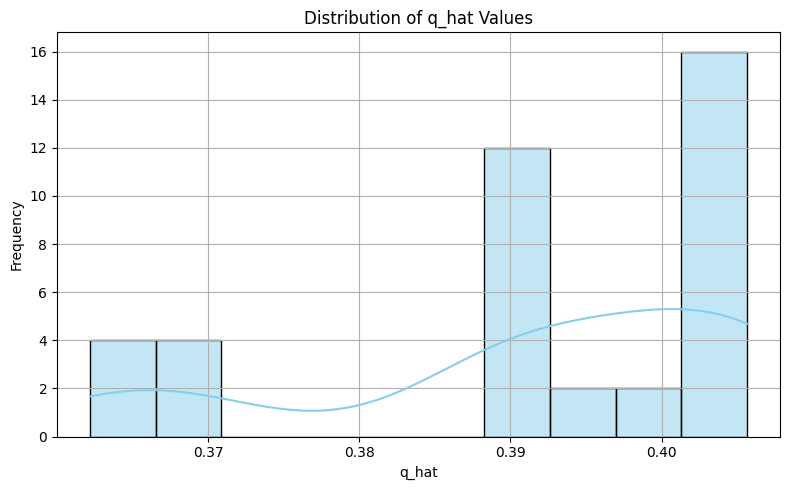

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of q_hat
plt.figure(figsize=(8, 5))
sns.histplot(df_agg["q_hat"], bins=10, kde=True, color="skyblue")
plt.title("Distribution of q_hat Values")
plt.xlabel("q_hat")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [89]:
X = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]]
y = df_agg[main_cp_metric]

In [90]:
X.head()

,universe_model,universe_exclude_features,universe_exclude_subgroups
0,penalized_logreg,nationality,keep-all
1,logreg,nationality,keep-all
2,logreg,none,drop-non-german
3,gbm,none,drop-non-german
4,logreg,sex,drop-non-german


In [91]:
X.shape

(40, 3)

In [92]:
y.shape

(40,)

### Main Effects of Settings Only (i.e. no interactions)

In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), # Converts categorical features to one-hot encoded format
).fit(X) # Fit the preprocessing pipeline to the input data X
X_processed = preprocessor.transform(X) # This creates a numeric matrix suitable for modeling

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.950682977815012

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [94]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+0.926,<BIAS>
+0.008,universe_model_elasticnet
+0.001,universe_exclude_subgroups_drop-non-german
+0.000,universe_exclude_features_nationality
-0.000,universe_exclude_features_none
-0.007,universe_model_rf
-0.013,universe_model_gbm


### Including Interactions

In [95]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.986308294574774

Weights of importance:

In [96]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+0.925,<BIAS>
+0.009,universe_model_elasticnet
+0.002,universe_model_logreg universe_exclude_subgroups_drop-non-german
+0.002,universe_model_penalized_logreg universe_exclude_subgroups_drop-non-german
+0.001,universe_model_elasticnet universe_exclude_subgroups_drop-non-german
+0.001,universe_exclude_subgroups_drop-non-german
+0.000,universe_exclude_features_sex universe_exclude_subgroups_drop-non-german
+0.000,universe_exclude_features_nationality
+0.000,universe_exclude_features_nationality^2
-0.000,universe_exclude_subgroups_keep-all


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [97]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df_agg[main_cp_metric])


In [98]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.047325,0.047325,0.100668,0.100668
universe_exclude_subgroups,0.028610,0.028610,0.035212,0.035212
universe_model,0.783342,0.783342,0.256836,0.256836


In [99]:
m_fanova.quantify_importance(save_to = "fanova_importance_interactions-overall_alpha_2.csv")

,level_0,level_1,level_2,individual importance,total importance,individual std,total std
2,universe_model,NaN,NaN,0.783342,0.783342,0.256836,2.568364e-01
5,universe_exclude_subgroups,universe_model,NaN,0.053962,0.865914,0.069228,2.005455e-01
0,universe_exclude_features,NaN,NaN,0.047325,0.047325,0.100668,1.006683e-01
4,universe_exclude_features,universe_model,NaN,0.036658,0.867326,0.047944,1.535731e-01
1,universe_exclude_subgroups,NaN,NaN,0.028610,0.028610,0.035212,3.521156e-02
6,universe_exclude_features,universe_exclude_subgroups,universe_model,0.028183,1.000000,0.041441,1.108197e-13
3,universe_exclude_features,universe_exclude_subgroups,NaN,0.021920,0.097854,0.045776,1.619042e-01


In [100]:
# Format

cols_to_format = [
    "individual importance",
    "total importance",
    "individual std",
    "total std"
]

fanova_interactions = m_fanova.quantify_importance()
fanova_interactions[cols_to_format] = fanova_interactions[cols_to_format].applymap(lambda x: f"{x:.4f}")
fanova_interactions

,level_0,level_1,level_2,individual importance,total importance,individual std,total std
2,universe_model,NaN,NaN,0.7833,0.7833,0.2568,0.2568
5,universe_exclude_subgroups,universe_model,NaN,0.0540,0.8659,0.0692,0.2005
0,universe_exclude_features,NaN,NaN,0.0473,0.0473,0.1007,0.1007
4,universe_exclude_features,universe_model,NaN,0.0367,0.8673,0.0479,0.1536
1,universe_exclude_subgroups,NaN,NaN,0.0286,0.0286,0.0352,0.0352
6,universe_exclude_features,universe_exclude_subgroups,universe_model,0.0282,1.0000,0.0414,0.0000
3,universe_exclude_features,universe_exclude_subgroups,NaN,0.0219,0.0979,0.0458,0.1619


In [25]:
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('universe_exclude_features', 'universe_model'), 0.0726473051204004), (('universe_exclude_subgroups', 'universe_model'), 0.009460675106850627), (('universe_exclude_features', 'universe_exclude_subgroups'), 0.008723394355438287)])


In [34]:
# Directory that will contain outputs from analysis

from pathlib import Path

ANALYSIS_OUTPUT_DIR = Path(".") / "analyses"
ANALYSIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [35]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(ANALYSIS_OUTPUT_DIR))

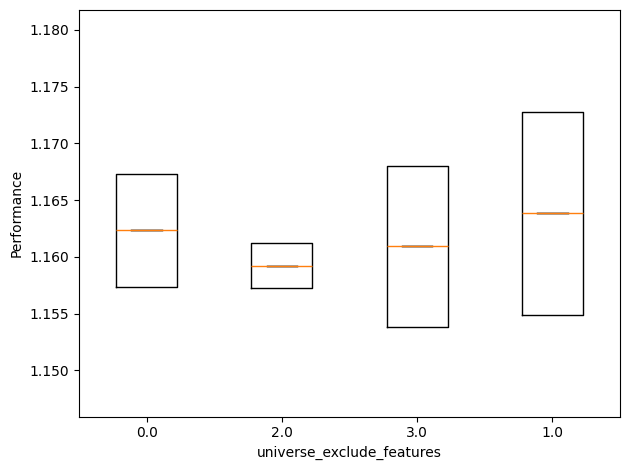

In [30]:
vis.plot_marginal(0)

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)
INFO:fanova.visualizer.Visualizer:creating results/interactive_plots


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

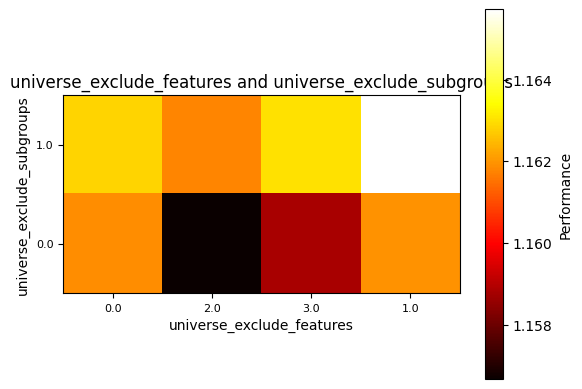

In [32]:
vis.plot_pairwise_marginal(['universe_exclude_features', 'universe_exclude_subgroups'])

## Quantify Importance with Partial Data

In [36]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [41]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [42]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)